# Scaling Computations using Parallel Computing

## Julian Samaroo and Przemysław Szufel

Before we start, load the packages we'll need (don't mind the warnings):

In [1]:
# Set our project directory
using Pkg
Pkg.activate(@__DIR__)

# Add some workers with threads
using Distributed
addprocs(2; exeflags=["--project=$(@__DIR__)", "--threads=2"])
# Now, packages get automatically loaded on all workers

using Revise

# Load Dagger (our parallel computing library)
using Dagger

# For benchmarking
using BenchmarkTools

# For plotting/visualization
using GraphViz
using Plots
using DataFrames

  Activating project at `~/2026_MIT_18.S096_Introduction-to-Julia-for-Data-Science/Day-3a_Parallel-and-distributed-computing`


Also, create some useful helper functions (we'll see what they do later):

In [2]:
function viz(f, n)
    while n > 1
        f()
    end
    Dagger.enable_logging!(;all_task_deps=true)
    result = f()
    logs = Dagger.fetch_logs!()
    Dagger.disable_logging!()
    display(Dagger.render_logs(logs, :plots_gantt; size=(1200, 400)))
    #display(Dagger.render_logs(logs, :graphviz))
    return result
end
macro viz(ex)
    quote
        viz(()->$ex, 1)
    end
end
macro viz2(ex)
    quote
        viz(()->$ex, 2)
    end
end

@viz (macro with 1 method)

### Some motivation

Everyone wants their code to go fast, and everyone would love if their code could work on any kind of hardware efficiently: multiple CPUs, multiple servers, GPUs, other accelerators, etc. You can just imagine running your code and suddenly all your hardware spins up, doing your bidding at full tilt.

Unfortunately, unless you're very knowledgeable about computer hardware, locking and atomics, latency hiding, distributed scheduling, GPU programming, etc., this is very difficult to accomplish by rolling your own solution.

# What is Dagger?

![](https://github.com/JuliaParallel/Dagger.jl/blob/master/docs/src/assets/logo-with-text.jpg?raw=true)

## Overview of Dagger.jl

- Unified task interface for multithreading, distributed, and GPU programming
- Distributed high-performance scheduler using machine learning
- APIs for programming with arrays, tables, and graphs
- Checkpointing and out-of-core enables solving large problems

### What difficult problems does Dagger solve?

- Cross-task dependency management
- Abstracting computation across servers and threads
- Dynamic workload balancing of heterogeneous tasks
- Automating data transfer while hiding latency
- Automatic GPU utilization and data conversion

## How to program with tasks

In Dagger, all tasks take any number of arguments, a function to call with those arguments, and produce a result:

In [3]:
t = Dagger.@spawn 1+2
@show t
fetch(t)

t = DTask (running)


3

That `Dagger.@spawn` operation (a Julia macro) wraps the `+` function and the arguments `1` and `2` in a Dagger task, and executes it asynchronously.  (You'll notice that it's a `DTask` object - this is short for "Dagger task").

Another thing to notice is that just like other "async/await"-style implementations, we need to call the `fetch` function to wait for the task to finish and get its result. If you don't call `fetch`, that's ok - it'll still run in the background, and you can `fetch` it whenever you're ready to see the result.

Like you might expect when working with functions, one task can use the result of another task as its input:

In [4]:
a = Dagger.@spawn 1+2
fetch(Dagger.@spawn 2*a)

6

Dagger will always execute your tasks in the order specified by its arguments (in the form of a "Directed Acyclic Graph", or "DAG", hence the name "Dagger"!)

It's easy to construct your program from a bunch of inter-dependent tasks:

In [5]:
@viz2 begin
    a = Dagger.@spawn 1 + 1
    b = Dagger.@spawn a * 2
    c = Dagger.@spawn a / 2
    d = Dagger.@spawn b - c
    fetch(d)
end

3.0

In the above code, Dagger can execute `b` and `c` in parallel, since they don't depend on each other:

In [6]:
# `a` ---> `b` --->
#  |              |
#  v              v
#  ------> `c` ->`d`

Conveniently, you don't have to tell Dagger to execute `b` and `c` in parallel - it's automatic! Dagger will automatically use all Julia threads to run computations, and will automatically balance each thread's workload to keep them busy. We'll show this in more depth momentarily.

And it's not just multithreading, Dagger also supports distributed computing with multiprocessing. Let's use the workers that we added at the beginning of this notebook and prove that Dagger will use them:

In [7]:
# We use @everywhere here to make sure all workers know about our `who_am_i` function
@everywhere function who_am_i()
    id = Distributed.myid() # Which worker are we? Starts from 1
    println("Hello from worker $id")
end

wait(Dagger.@spawn scope=Dagger.scope(worker=1) who_am_i()); # This will definitely run locally (on worker 1)
wait(Dagger.@spawn scope=Dagger.scope(worker=2) who_am_i()); # This will definitely run on worker 2
wait(Dagger.@spawn scope=Dagger.scope(worker=3) who_am_i()); # This will definitely run on worker 3
wait(Dagger.@spawn who_am_i()); # This might run locally or on any worker; try re-running this!

Hello from worker 1
      From worker 2:	Hello from worker 2
      From worker 3:	Hello from worker 3
Hello from worker 1


So wait, why did we need the `scope=...` thing to make sure that Dagger runs our code on workers 2 and 3? Unlike other libraries, Dagger can run your code on worker and any thread, whenever it wants! `scope=...` forces Dagger to constrain itself to executing your code only where you request.

Hold up, isn't this a source of madness? How can I ever write reliable code with Dagger? Do I just need to litter `scope=...` everywhere? How is this any better than Julia's `remotecall_fetch`, `@spawnat`, and friends, which are slightly less verbose?

Dagger takes a different approach to high performance computing: instead of architecting your code around a specific workload/data distribution (which takes expertise to implement and maintain, and adds a lot of complexity to otherwise simple code), Dagger gives you the freedom to write code which is free from hardware-specific minutia.

Instead of needing to decide where to run your code, and then needing to also make sure your data gets there first, Dagger just asks you for three things: your functions, their arguments, and how they depend on each other. Dagger's scheduler handles the rest - it moves data around, schedules your functions to run close to that data, and balances execution of your functions so that they exploit all the computing resources you have available.

Forget learning about multithreading, atomics, parallel data movement, even GPU computing - this is the future! Just write your code, and let Dagger handle those pesky details for you.

Let's extend our `who_am_i` function to see how Dagger really shines:

In [8]:
# We use @everywhere here to make sure all workers know about our `who_am_i_extended` function
@everywhere function who_am_i_extended()
    id = Distributed.myid()
    tid = Threads.threadid()
    println("Hello from worker $id's thread $tid")
end

wait.([Dagger.@spawn who_am_i_extended() for i in 1:20]); # These can each run on any worker and any thread

Hello from worker 1's thread 5
Hello from worker 1's thread 2
Hello from worker 1's thread 4
Hello from worker 1's thread 2
Hello from worker 1's thread 5
Hello from worker 1's thread 4
Hello from worker 1's thread 2
Hello from worker 1's thread 5
Hello from worker 1's thread 4
Hello from worker 1's thread 2
Hello from worker 1's thread 4
Hello from worker 1's thread 5
Hello from worker 1's thread 2
Hello from worker 1's thread 4
Hello from worker 1's thread 5
Hello from worker 1's thread 2
Hello from worker 1's thread 4
Hello from worker 1's thread 2
Hello from worker 1's thread 4
Hello from worker 1's thread 5


Congratualations, you are now a high-performance computing practitioner! You've just parallelized the execution of a bunch of functions without doing much of anything, which is something that would be quite difficult to accomplish with other libraries.

Of course, this example is quite simple and doesn't do much. Let's show off Dagger's performance with a problem which does some heavy computations:

In [9]:
# A function which does something expensive with arrays
@everywhere function some_function(i, arrs...)
    @nospecialize arrs
    total = 0.0
    for arr in arrs
        total += i * sum(inv(arr))
    end
    return rand(0.0:abs(total), 100, 100)
end

# A function which generates a large DAG of expensive computations
function create_dag(f, Ns...; use_dagger=false)
    last_nodes = []
    current_nodes = []
    
    push!(last_nodes, rand(100, 100))

    for N in Ns
        println("Generating $N nodes")
        for i in 1:N
            if use_dagger
                push!(current_nodes, Dagger.@spawn f(i, last_nodes...))
            else
                push!(current_nodes, f(i, last_nodes...))
            end
        end
        empty!(last_nodes)
        append!(last_nodes, current_nodes)
        empty!(current_nodes)
    end
    
    return fetch.(last_nodes)
end

# Disable BLAS multithreading - while BLAS multithreading is very efficient,
# many workloads do not automatically parallelize themselves :)
using LinearAlgebra; BLAS.set_num_threads(1)

In [10]:
# Let's try just running this code in serial:
@time create_dag(some_function, 100, 50; use_dagger=false);

Generating 100 nodes
Generating 50 nodes
  4.567640 seconds (13.71 M allocations: 1.314 GiB, 10.17% gc time, 212.16% compilation time: 55% of which was recompilation)


In [11]:
# Let's go faster with Dagger:
@viz @time create_dag(some_function, 100, 50; use_dagger=true);

Generating 100 nodes
Generating 50 nodes
  1.805737 seconds (9.88 M allocations: 1.127 GiB, 17.04% gc time, 162 lock conflicts, 180.32% compilation time: <1% of which was recompilation)


Of course, Dagger's performance is dependent on the problem. In the above case, we don't get linear scaling because linear algebra operations are so homogeneous (thus bottlenecking within the CPU processor) and use so much memory (thus bottlenecking the CPU caches).

Ok, now let's take a look at a problem which, while being still homoegeneous in nature, utilizes less memory per function:

In [12]:
using Random, Statistics

# This function allocates a lot of memory, but doesn't need to transfer it
@everywhere function delay(job_size)
    z = Vector{Float64}(undef, 1_000_000)
    sum(std(rand!(z)) for i in 1:round(Int, 660*job_size))
end

In [13]:
function delay_n_cpu(n=20)
    # Calling it like this generates one long-running task, and a bunch of shorter-running tasks
    [delay(i <= 1 ? 1.5 + i : round((i % 3)/5 .+ 0.1; digits=2)) for i in 1:n]
end

delay_n_cpu (generic function with 2 methods)

In [14]:
@time delay_n_cpu();

 12.295052 seconds (14.01 M allocations: 874.540 MiB, 3.05% gc time, 16 lock conflicts, 150.58% compilation time: 36% of which was recompilation)


In [15]:
function delay_n_dagger(n=20)
    wait.([(Dagger.@spawn delay(i <= 1 ? 1.5 + i : round((i % 3)/5 .+ 0.1; digits=2))) for i in 1:n])
end

delay_n_dagger (generic function with 2 methods)

  9.408632 seconds (6.13 M allocations: 525.309 MiB, 0.90% gc time, 80 lock conflicts, 118.06% compilation time: <1% of which was recompilation)


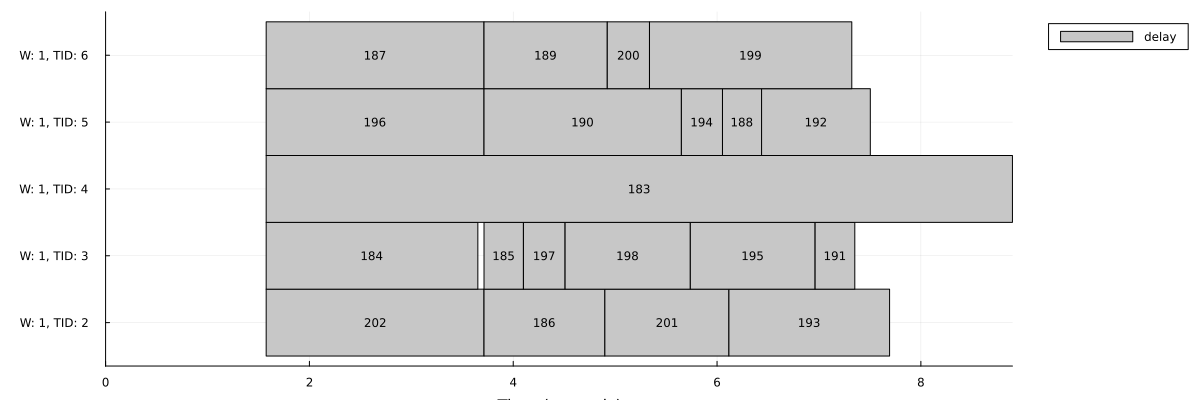

In [16]:
# Let's watch Dagger optimize the execution of this problem:
@viz2 @time delay_n_dagger();

This problem has no cross-task dependencies, making it very easy to parallelize.

## Data Movement

Tasks can run anywhere, which also means that their data must move with them. Dagger automatically moves data from where it is, to where it needs to be, as necessary:

In [17]:
function time_data_xfer()
	# Make some data on worker 2
	A = Dagger.with_options(scope=Dagger.scope(worker=2)) do
		Dagger.@spawn rand(10240,1024)
	end
	wait(A)

	# Use the data on the same worker
	t_local = @timed(Dagger.with_options(scope=Dagger.scope(worker=2)) do
		fetch(Dagger.@spawn sum(A))
	end).time

	# Use the data on a different worker
	t_remote = @timed(Dagger.with_options(scope=Dagger.scope(worker=3)) do
		fetch(Dagger.@spawn sum(A))
	end).time
	return t_remote / t_local
end

time_data_xfer (generic function with 1 method)

In [18]:
println("Speedup when data isn't moved around:")
time_data_xfer()

Speedup when data isn't moved around:


2.396255128674203

Of course, it would be quite silly for Dagger to always move data around when that data gets really big - sometimes it's better for the data not to move at all. Thankfully, Dagger knows this, and will schedule tasks such that if it truly is faster to execute a task where the data is, it will do so. We can see this pretty reliably with a simple example:

In [19]:
@everywhere function where_am_i_data(arr, name)
	println("Accessing $name (sum $(sum(arr)))")
end
function time_data_xfer_no_move()
	# Make some data on worker 2
	A = Dagger.with_options(scope=Dagger.scope(worker=2)) do
		Dagger.@spawn rand(1024,1024)
	end
	# Make some data on worker 3
	B = Dagger.with_options(scope=Dagger.scope(worker=3)) do
		Dagger.@spawn rand(1024,1024)
	end
	wait(A)
	wait(B)

	# Let Dagger choose where to execute
	for i in 1:5
		wait(Dagger.@spawn where_am_i_data(A, :A))
	end
	for i in 1:5
		wait(Dagger.@spawn where_am_i_data(B, :B))
	end
end

time_data_xfer_no_move (generic function with 1 method)

In [20]:
time_data_xfer_no_move()

Accessing A (sum 524202.5098472389)
Accessing A (sum 524202.5098472389)
Accessing A (sum 524202.5098472389)
Accessing A (sum 524202.5098472389)
Accessing A (sum 524202.5098472389)
Accessing B (sum 524143.8000922195)
Accessing B (sum 524143.8000922195)
Accessing B (sum 524143.8000922195)
Accessing B (sum 524143.8000922195)
Accessing B (sum 524143.8000922195)


We can see that Dagger's scheduler (the logic that chooses where tasks should execute) has decided to schedule tasks on the same worker that holds the data that they're accessing. This is the optimal choice to make, but it's also pretty obvious.

What happens if Dagger has conflicting priorities (say, a task accesses data spread across multiple workers)? Let's check:

In [21]:
@everywhere function where_am_i_data_split(a_arr, a_name, b_arr, b_name)
	println("Accessing $a_name (sum $(sum(a_arr))) and $b_name (sum $(sum(b_arr)))")
end
function time_data_xfer_maybe_move()
	# Make some data on worker 2
	A = Dagger.with_options(scope=Dagger.scope(worker=2)) do
		Dagger.@spawn rand(1024,1024)
	end
	# Make some data on worker 3
	B = Dagger.with_options(scope=Dagger.scope(worker=3)) do
		Dagger.@spawn rand(1024,1024)
	end
	wait(A)
	wait(B)

	# Let Dagger choose where to execute
	for i in 1:10
		wait(Dagger.@spawn where_am_i_data_split(A, :A, B, :B))
	end
end

time_data_xfer_maybe_move (generic function with 1 method)

In [22]:
time_data_xfer_maybe_move()

Accessing A (sum 524463.9857693454) and B (sum 524151.66891520837)
Accessing A (sum 524463.9857693454) and B (sum 524151.66891520837)
Accessing A (sum 524463.9857693454) and B (sum 524151.66891520837)
Accessing A (sum 524463.9857693454) and B (sum 524151.66891520837)
Accessing A (sum 524463.9857693454) and B (sum 524151.66891520837)
Accessing A (sum 524463.9857693454) and B (sum 524151.66891520837)
Accessing A (sum 524463.9857693454) and B (sum 524151.66891520837)
Accessing A (sum 524463.9857693454) and B (sum 524151.66891520837)
Accessing A (sum 524463.9857693454) and B (sum 524151.66891520837)
Accessing A (sum 524463.9857693454) and B (sum 524151.66891520837)


Interesting! Dagger chose to schedule these tasks almost evenly across workers 2 and 3. This makes sense, if you think about it - there's no benefit to picking worker 2 vs worker 3, so we might as well spread the work between them.

This is the sort of stuff that feels obvious to us as humans, but is quite a lot of work to implement everytime you want to solve a parallel computing problem (especially considering that Julia's Distributed library doesn't do this for you). It can be invaluable to have a smart scheduler on your side when writing parallel code!

Now that we've seen how Dagger's task system works, and the benefits it provides, let's take a look at the user-friendly APIs that build on top of it - arrays and tables.

## Array Programming with Dagger

Arrays are super useful! Julia uses them all throughout its codebase, and nearly every Julia package uses them heavily. They are simple, storage-efficient, and have a huge range of available functionality. You can build anything with the right set of arrays and algorithms that use them.

All of that said, parallel array operations is not really first-class in Julia - operations like `sum`, `reduce`, broadcasting, and much more, don't use multithreading at all, even if you have a bunch of CPUs and have started Julia with multiple threads. While this may eventually change in future versions of Julia, it will probably only happen for a handful of array operations at a time, and won't just magically apply to the operations that your code uses.

Of course, Julia *does* have first-class multithreading support, so we can always roll our own multithreaded array operations:

In [23]:
function mt_sum(A::Array{T}) where T
    nchunks = Threads.nthreads()
    chunksize = cld(length(A), nchunks)
    reds = zeros(T, nchunks)
    @sync for (idx, chunk) in enumerate(Iterators.partition(A, chunksize))
        Threads.@spawn begin
            reds[idx] = sum(chunk)
        end
    end
    return sum(reds)
end

mt_sum (generic function with 1 method)

In [24]:
A = rand(10240, 10240)
@assert sum(A) ≈ mt_sum(A)
println("Single-threaded:")
@btime sum($A)
println("Multi-threaded:")
@btime mt_sum($A)

Single-threaded:
  52.897 ms (18132 allocations: 907.62 KiB)
Multi-threaded:
  35.987 ms (58 allocations: 3.44 KiB)


5.242947093694518e7

So it can definitely be done, but it requires some work, and you have to redo that work for every operation you want multithreaded.

Also, the above code doesn't support distributed execution. If you want that, there's a different way to write the sum:

In [25]:
function dist_sum(A::Array{T}) where T
    nchunks = nprocs()
    chunksize = cld(length(A), nchunks)
    return sum(pmap(sum, Iterators.partition(A, chunksize)))
end

dist_sum (generic function with 1 method)

In [26]:
A = rand(10240)
@assert sum(A) ≈ dist_sum(A)
println("Single-worker:")
@btime sum($A)
println("Multi-worker:")
@btime dist_sum($A)

Single-worker:
  1.464 μs (0 allocations: 0 bytes)
Multi-worker:
  681.339 μs (388 allocations: 260.97 KiB)


5101.547893235687

Not too hard, but also not fast, it blows up if we use really big arrays, and it would be nice if we could use both multithreading and distributed. Let's try rolling our own by combining the two above implementations:

In [27]:
# We need to support slices of arrays, so redefine this for AbstractArray
@everywhere function mt_sum(A::AbstractArray{T}) where T
    nchunks = Threads.nthreads()
    chunksize = cld(length(A), nchunks)
    reds = zeros(T, nchunks)
    @sync for (idx, chunk) in enumerate(Iterators.partition(A, chunksize))
        Threads.@spawn begin
            reds[idx] = sum(chunk)
        end
    end
    return sum(reds)
end
function mt_dist_sum(A::Array{T}) where T
    nchunks = nprocs()
    chunksize = cld(length(A), nchunks)
    return sum(pmap(mt_sum, Iterators.partition(A, chunksize)))
end

mt_dist_sum (generic function with 1 method)

In [28]:
A = rand(10240, 10240)
@assert sum(A) ≈ mt_dist_sum(A)
println("Single-worker, single-threaded:")
@btime sum($A)
println("Multi-worker, multi-threaded:")
@btime mt_dist_sum($A)

Single-worker, single-threaded:
  52.712 ms (18132 allocations: 907.62 KiB)
Multi-worker, multi-threaded:
  1.034 s (626996 allocations: 834.60 MiB)


5.24280434529497e7

Ok, it's workable, but there's something that's rather annoying about this implementation - we need to allocate the array on one worker, then send portions of it to all the other workers, only to copy the results back to the original worker. What if we could construct the chunks of the array on the other workers to start with, and then just let the workers compute their local sums?

Enter the `DArray`:

In [29]:
# Create a random distributed array with chunks of size 1024 x 1024
DA = fetch(rand(Blocks(1024, 1024), 10240, 10240))

if VERSION >= v"1.12.0"
    error("Julia 1.12.4 has a compiler bug that causes sum(DA) to take forever (sad!)")
end

# Do a distributed and multithreaded sum
@btime sum($DA)

# Make sure results are correct
@assert sum(collect(DA)) ≈ sum(DA)

LoadError: Julia 1.12.4 has a compiler bug that causes sum(DA) to take forever

Not bad! Performance isn't perfect, but it's not too bad for an automatically distributed and multithreaded operation (which is generically implemented, and will have similar performance for all kinds of reductions). This performance will improve over time as Dagger itself improves.

You can see that just like Dagger tasks, Dagger arrays (the `DArray`) is lazy. `fetch` is used to ensure that operations are completed, and `collect` is used to convert a `DArray` into a regular `Array`.

The `DArray` supports a variety of array operations just like Julia's `Array`s:

In [30]:
# Create a local array (not distributeed)
A = rand(64, 64)

# Let's distribute A across our workers by partitioning in 16 x 16 blocks
DA = distribute(A, Blocks(16, 16))

# Do a map operation on it:
DB = map(x->x*2, DA)

# And get the result back as an Array:
collect(DB)

64×64 Matrix{Float64}:
 0.730737  0.38644     0.500829  1.68406   …  0.943376  0.320231  1.86287
 1.34021   1.14937     1.87896   0.693105     1.75028   1.0128    1.03016
 0.359647  0.479782    0.879972  1.90308      1.22536   0.953377  1.3316
 0.460912  1.27484     0.533304  0.372686     0.288493  0.788891  0.751706
 0.314005  0.00879193  0.213891  0.233148     1.11847   0.79666   0.905324
 0.504438  0.302567    1.98856   1.1791    …  0.439734  0.965973  0.697838
 0.160195  1.00074     0.46471   1.90638      0.869887  0.273245  0.380811
 1.35341   1.62315     0.4206    1.49911      1.82149   1.34333   0.4542
 1.08988   1.57559     1.16742   0.359344     1.34574   0.324351  1.85986
 0.945181  0.316403    0.946984  1.31915      0.487585  1.01729   1.75846
 1.64105   0.375208    0.371584  0.393202  …  0.446374  1.28288   0.00557144
 1.3133    0.232596    1.46606   1.71009      1.96909   1.63816   1.83174
 1.53141   0.987473    1.138     1.12678      1.1769    1.00842   1.74801
 ⋮        

Complex operations like broadcasting work too:

In [31]:
collect(DA .* 2 .+ DB)

64×64 Matrix{Float64}:
 1.46147   0.77288    1.00166   3.36812   …  1.88675   0.640463  3.72575
 2.68042   2.29874    3.75793   1.38621      3.50056   2.02559   2.06032
 0.719295  0.959564   1.75994   3.80616      2.45071   1.90675   2.66321
 0.921823  2.54968    1.06661   0.745372     0.576987  1.57778   1.50341
 0.628009  0.0175839  0.427783  0.466296     2.23694   1.59332   1.81065
 1.00888   0.605134   3.97712   2.35821   …  0.879468  1.93195   1.39568
 0.320391  2.00148    0.92942   3.81277      1.73977   0.546489  0.761622
 2.70681   3.2463     0.841201  2.99823      3.64299   2.68667   0.908401
 2.17975   3.15119    2.33484   0.718688     2.69148   0.648702  3.71973
 1.89036   0.632805   1.89397   2.63829      0.97517   2.03457   3.51691
 3.28209   0.750416   0.743168  0.786403  …  0.892747  2.56575   0.0111429
 2.6266    0.465192   2.93211   3.42018      3.93818   3.27633   3.66349
 3.06283   1.97495    2.276     2.25357      2.3538    2.01684   3.49602
 ⋮                      

Ok, but where's the proof that this is actually distributed or multithreaded? Well, we can easily see which workers and threads it's operating on:

In [32]:
DC = rand(Blocks(4, 4), 16, 16)

# Which worker is running our tasks?
collect(map(x->Distributed.myid(), DC))

16×16 Matrix{Int64}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

In [33]:
# And which threads are running our tasks?
collect(map(x->Threads.threadid(), DC))

16×16 Matrix{Int64}:
 2  2  2  2  6  6  6  6  6  6  6  6  2  2  2  2
 2  2  2  2  6  6  6  6  6  6  6  6  2  2  2  2
 2  2  2  2  6  6  6  6  6  6  6  6  2  2  2  2
 2  2  2  2  6  6  6  6  6  6  6  6  2  2  2  2
 6  6  6  6  4  4  4  4  2  2  2  2  4  4  4  4
 6  6  6  6  4  4  4  4  2  2  2  2  4  4  4  4
 6  6  6  6  4  4  4  4  2  2  2  2  4  4  4  4
 6  6  6  6  4  4  4  4  2  2  2  2  4  4  4  4
 4  4  4  4  5  5  5  5  5  5  5  5  3  3  3  3
 4  4  4  4  5  5  5  5  5  5  5  5  3  3  3  3
 4  4  4  4  5  5  5  5  5  5  5  5  3  3  3  3
 4  4  4  4  5  5  5  5  5  5  5  5  3  3  3  3
 3  3  3  3  3  3  3  3  2  2  2  2  4  4  4  4
 3  3  3  3  3  3  3  3  2  2  2  2  4  4  4  4
 3  3  3  3  3  3  3  3  2  2  2  2  4  4  4  4
 3  3  3  3  3  3  3  3  2  2  2  2  4  4  4  4

You might be wondering, how does the `DArray` work? Is it a magical built-in? Well, it's really just a generic container around Dagger tasks, which is easy enough to see for yourself:

In [34]:
DC.chunks

4×4 Matrix{Any}:
 DTask (finished)  DTask (finished)  DTask (finished)  DTask (finished)
 DTask (finished)  DTask (finished)  DTask (finished)  DTask (finished)
 DTask (finished)  DTask (finished)  DTask (finished)  DTask (finished)
 DTask (finished)  DTask (finished)  DTask (finished)  DTask (finished)

Since this array is 16 x 16 total elements and partitioned into chunks of 4 x 4, we thus have 4 x 4 Dagger tasks, one for each chunk of the partitioned array. You can check the value of any of these chunks by `fetch`ing them, as you'd expect:

In [35]:
fetch(DC.chunks[3,4])

4×4 Matrix{Float64}:
 0.338724  0.0412945  0.178439  0.795914
 0.308952  0.249618   0.658482  0.813683
 0.928249  0.405555   0.48018   0.14506
 0.425351  0.0933829  0.8864    0.0915328

Operations on the `DArray` simply take these tasks as input, passing them into other Dagger tasks, and putting the resulting tasks into a new `DArray` that's returned to you. All of the computations and data movement happen in Dagger in the background.

Feel free to try out other useful operations:

In [36]:
# Reshape and matrix-matrix multiply
collect(reshape(DC, 8, 32) * reshape(DC, 32, 8))

8×8 Matrix{Float64}:
 7.97874  8.30311  7.48644  5.97097  6.84231  8.46413  7.64696  6.37097
 7.49427  8.39341  6.4531   6.76524  5.60683  7.25645  7.15782  6.04156
 7.79449  8.23226  7.62491  6.30431  8.71648  6.8005   7.31893  6.61713
 8.58092  8.97928  8.15923  6.62368  7.79855  8.35293  8.13637  6.30146
 6.81623  8.81961  7.1097   5.08265  6.85589  7.17179  6.60992  5.89709
 7.17135  8.00166  6.89053  6.92054  7.6398   7.97213  7.18932  5.57269
 8.68257  8.33957  7.98482  6.6115   7.52978  8.08631  7.77274  6.58055
 7.54186  8.30245  7.33797  7.0044   7.77546  7.97545  7.49329  5.96509

In [37]:
# Sorting
DD = rand(Blocks(16), 64)
collect(sort(DD))

64-element Vector{Float64}:
 0.03608880845216478
 0.0412021997944495
 0.05602402720769806
 0.11156355086386616
 0.11305812595986564
 0.12070249295198832
 0.12422656692723655
 0.13250181964468843
 0.14124305995880537
 0.17219582925929844
 0.17880009907380323
 0.1848559476369045
 0.2335604537899445
 ⋮
 0.8091112594517115
 0.8487679200684818
 0.8691395188336248
 0.8776185032323501
 0.9066481363680453
 0.9210849349185223
 0.9219319514062077
 0.9236837302665882
 0.9432573725986343
 0.9724424362429877
 0.9729100793759264
 0.9941655424980324

## Tabular Programming in Dagger

Arrays are cool and super useful, but for certain use cases (like tabular data analysis, ETL operations, database interfacing, etc.), they just don't really cut it. In Julia, users can use DataFrames.jl to gain access to a very capable, high-performance table implementation. DataFrames is very well-tuned and even automatically multithreads many operations. If your data is small enough to fit on a single worker and in-memory, the DataFrame is a great option!

In [38]:
using DataFrames

In [39]:
df1 = DataFrame(a=rand('a':'z', 1000), b=rand(1000))
df2 = DataFrame(a=rand('a':'z', 1000), c=rand(1:10, 1000))
df3 = innerjoin(df1, df2, on=:a)

Row,a,b,c
,Char,Float64,Int64
1,v,0.360626,5
2,v,0.436404,5
3,v,0.0647193,5
4,v,0.532593,5
5,v,0.565222,5
6,v,0.155959,5
7,v,0.391472,5
8,v,0.651889,5
9,v,0.50774,5



However, there are three main areas where the DataFrame won't help you very much:
- Your data is too big to fit in RAM
- You have multiple servers and want to distribute your table operations across them
- DataFrames doesn't have a multithreaded implementation of the operation that's slowing you down

For these cases and more, we can do the simple thing and just turn each `DataFrame` column into a `DArray`:

In [40]:
dt3 = DataFrame(Dict(col=>DArray(df3[!,col]) for col in names(df3)))

Row,a,b,c
,Char,Float64,Int64
1,v,0.360626,5
2,v,0.436404,5
3,v,0.0647193,5
4,v,0.532593,5
5,v,0.565222,5
6,v,0.155959,5
7,v,0.391472,5
8,v,0.651889,5
9,v,0.50774,5


It's that easy! Just like a normal `DataFrame`, we can do the usual set of expected operations:

In [41]:
select(dt3, [:a, :c])[1:10,:]

Row,a,c
,Char,Int64
1,v,5
2,v,5
3,v,5
4,v,5
5,v,5
6,v,5
7,v,5
8,v,5
9,v,5


In [49]:
first(combine(groupby(dt3, :a), :b => sum), 10)

  1.190494 seconds (7.81 M allocations: 239.131 MiB, 47 lock conflicts, 12.84% compilation time: 68% of which was recompilation)


Row,a,b_sum
,Char,Float64
1,v,599.422
2,u,818.495
3,y,1003.04
4,c,668.856
5,i,876.864
6,e,1081.46
7,o,656.53
8,g,704.964
9,p,1064.03


Some things are not yet optimized (joins for example), so we may have to convert columns back to Arrays. Otherwise this next part takes way too long!

In [ ]:
dt3_array = DataFrame(Dict(col=>collect(dt3[!,col]) for col in names(dt3)))
@time begin
    dt4 = leftjoin(dt3_array, DataFrame(a=rand('a':'z', 100), d=rand(100)), on=:a)
    first(dt4, 10)
end

## Addendum

Dagger is a powerful toolkit for parallel programming, with a variety of useful APIs for doing useful computations and analyses, and which integrate nicely with Julia's large and growing ecosystem. However, there are definitely some areas that are a work in progress that I wanted to mention before we wrap up:
- The `DArray` is missing some useful operators, particularly support code for combinations with e.g. DataFrames
- Dagger typically uses more memory than hand-rolled solutions

All of these are on the Todo list for the next few months, and should be significantly improved as more contributions to Dagger and friends are made by maintainers and contributors.